# Diffusion map

### Abstract

Diffusion map is a dimensionality reduction method that find meaningful structure which points are embedded. By studying this technique $^{[1]}$ $^{[2]}$ and a paper that claim to have a better algorithm for diffusiom map $^{[3]}$, I will first introduce this method, then display the new algorithm.

### Introduction

For morden data sets (e.g., financial and consumer data, DNA microarrays, text documents), datas are offen high-dimensional, noisy and unordered, which makes it hard to find meaningful structures. Diffusion map is a mathematical technique for analysing and organising such data, which is done by reducing the dimension of points, that is, finding a lower-dimensional manifold which points are embedded. The new representation of points in such structure should preserve the important relationships, such as local mutual distance, between them.

Unlike other method for dimensionality reduction (such as Principal Component Cnalysis, PCA), diffusion map is still usful when datas in data space have nonlinear shapes, since it focus on discovering the underlying manifold. In comparisons, the technique is also robust to noise perturbation and computationally inexpensive.

### Framework

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^p$, we construct the diffusion map by using steps in the paper$^{[3]}$:

1. ##### Define a kernel and create the kernel matrix

>Consider Guassian kernel $$ k(x_{i},x_{j}) = \exp(-\frac{\lVert x_{i}-x_{j} \rVert^2}{\sigma_i \sigma_j}) $$
where $$ \sigma_i=\lVert x_i-x_s \rVert^2 $$ and $x_s$ is the $s$'th neighber of point $x_i$.  
Define the kernel matrix $K$, with entries $ K_{ij}=k(x_{i},x_{j}) $. 

Note that $K$ is a $n*n$ symmetric matrix, the value of the entries is between 0 and 1, and is equal to 0 on the diagonal. Also, it is small if two data points, $x_i$ and $x_j$, are far away from each other in the data space; and is large if opposite.

Next, we bring up the connectivity between two data points $x_i$ and $x_j$, which is consider as the probability of jumping from $x_i$ to $x_j$ in one step of random walk. The relation between probability function and kernel function is
$$ p(x,y)=\frac{k(x,y)}{\sum_{y\in X} k(x,y)} $$

Define the diffusion matrix $P$, with entries $ P_{ij}=p(x_{i},x_{j}) $. Note that $P$ is not symmetric and has a discrete sequence of eigenvalues $1=\lambda_0 > \lvert \lambda_1 \rvert \geq \lvert \lambda_2 \rvert \geq \cdots$.

Let $$ D=
\left[
\begin{matrix}
 \sum_{y\in X} k(x_1,y)      &0      & \cdots &0      \\
 0      &\sum_{y\in X} k(x_2,y)      & \cdots &0      \\
 \vdots & \vdots & \ddots & \vdots \\
 0      &0      & \cdots & \sum_{y\in X} k(x_n,y)     \\
\end{matrix}
\right]
$$ be a $n*n$ diagonal matrix, then $ P=D^{-1}K $. Consider another matrix $Q$, define as $ Q=D^{1/2}P D^{-1/2} $, we have that
* $Q$ is symmetric.
* $Q$ has same eigenvalues as $P$.
* eigenvectors of $Q$, denoted as $e_k$, are multiplied by $D^{-1/2}$ and $D^{1/2}$ to get the right and left eigenvectors of $P$ respectively.

2. ##### Find matrix $Q$

Althouth $P$ is what we need, it is more convenient for us to compute the matrix $Q$. Since $$ Q=D^{1/2}P D^{-1/2}=D^{1/2}(D^{-1}K) D^{-1/2}=D^{-1/2}K D^{-1/2} $$, 
it means that we should 
>divide entries of $K$ by the product of root number of the sum of the related row and column to get the matrix $Q$.

3. ##### Find eigenvectors of $Q$ and form the matrix $Z$

> Simply compute the first $c$ largest eigenvalues of $Q$ and get the corresponding eigenvectors, $e_1,...,e_n$,  
then define the matrix $Z=
\left[
\begin{matrix} e_1 &e_2 &\cdots &e_n \end{matrix}
\right]
\in \mathbb{R}^{n \times c}
$

4. ##### Get the diffusion map and treat each row as a point coordinate

>define a diffusion map $Y$, which maps corrdinates between data and diffusion space, with its entries $$ Y_{ij}=\frac{Z_{ij}}{(\sum_{j=1}^{c} Z_{ij}^2)^{1/2}} $$  
It is the row-normalize matrix of $Z$.

Dimensional reduction is done by neglecting certain dimensions in the diffusion space, since the eigenvalues indicate the importance of each dimension, and is arrange in descending power as we mention earlier.

5. ##### Cluster via k-means

>Using k-means function to get the labeling of the datas, then we can show the result.

### Implement

This is a Python code following paper $^{[3]}$'s algorithm.

1. #### import some libraries for programming

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


2. #### Load the data

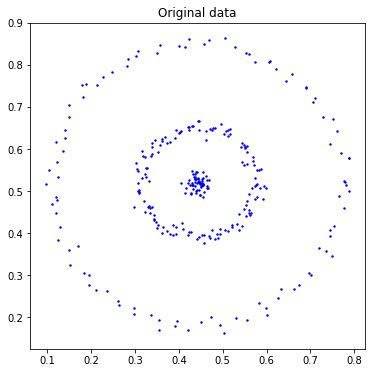

In [2]:
from scipy.io import loadmat

ori = loadmat('Data/Data2.mat')

n = len(ori['data'])       #number of points
p = len(ori['data'][0])    #dimension of points

for i in range(n): plt.scatter(ori['data'][i][0],ori['data'][i][1], s=2, c="blue")
plt.title("Original data")
plt.gcf().set_size_inches(6,6)
plt.show()

3. #### Construct diffusion map

######  3.1 Define functions

The functioning of get_K is to get the Guassian kernel matrix.

In [3]:
def get_K(D, sigma):
    list1=[]

    for i in range(n):
        for j in range(n):
            list1.append( exp(-D[i][j]*D[i][j]/(sigma[i]*sigma[j])) )
    K = array(list1).reshape(n, n)
    
    return K    #Guassian kernel matrix

The functioning of get_Q is to get the matrix $Q$ we mention above.

In [4]:
from scipy.sparse import csr_matrix

def get_Q(K):
    list1=[]
    list2=[]
    
    for i in range(n): list1.append( sqrt(sum(K[i])) )
    v = array(list1).reshape(n,1)    #v is a matrix helps normalize K
    
    Q = K/(v*v.T)    #v*v.T is a n*n symmetric matrix.
                     #the multiplication and division is applied to each element,
                     #not the matrix operations.
    
    #turn Q into a sparse matrix to speed up calculation
    threshold = 5e-6
    for i in range(n):
        for j in range(n):
            if Q[i][j]>threshold: list2.append(1.)
            else: list2.append(0.)
    a = array(list2).reshape(n, n)
    Q = csr_matrix(Q*a, dtype=float)
    
    return Q    #Q is the matrix we define earlier, i.e., Q=D^(-1/2)KD^(-1/2)

The functioning of get_eig is to get the eigenvectors of $Q$. 

In [5]:
from scipy.sparse.linalg import svds

def get_eig(Q, c):
    list1=[]
    
    [U, S, V] = svds(Q,c+1)    #compute the largest c singular values/vectors for a sparse matrix
                               #since Q is a real symmetric matrix, singular values and non-negative
                               #eigenvalues coincide

    for i in range(n): U[i]=flip(U[i])
    for i in range(n):
        for j in range(c):
            list1.append(U[i][j])
    Z = array(list1).reshape(n, c)
    
    return Z    #matrix of eigenvectors of Q

The functioning of get_Y is to construct the diffusion map.

In [21]:
def get_Y(Z, c):
    list1=[]
    
    for i in range(n):
        tempsum=0
        for j in range(c): tempsum = tempsum + Z[i][j]*Z[i][j]
        for j in range(c): list1.append(sqrt(tempsum))
    normalize_mat = array(list1).reshape(n,c)
    
    Y = Z/normalize_mat    #entries division
       
    return Y    #diffusion map

>###### 3.2 Set parameters for diffusion map

D : matrix of Euclidean distance of data points in $\mathbb{R}^p$.  
c : the largest $c$ eigenvalues, that is, the largest dimension we consider.  
s : parameter $s$ in the Guassian kernel function.  
sigma : a list of $\sigma_i$, which is required in the Guassian kernel function.

In [14]:
from scipy.spatial.distance import squareform, pdist
D = squareform(pdist(ori['data']))
c = 10

s = 7
sigma=[]
D_sort = sort(D,1)    # distance of one point to another arrange in descending power
for i in range(n): sigma.append( D_sort[i][s+1] )

###### 3.3 Conclude the steps above

In [15]:
def diffuse(D, sigma, c):
    
    K = get_K(D, sigma)
    Q = get_Q(K)
    Z = get_eig(Q, c)
    Y = get_Y(Z, c)

    return Y

In [16]:
Y = diffuse(D, sigma, c)

###### 3.4 Show the diffusion space

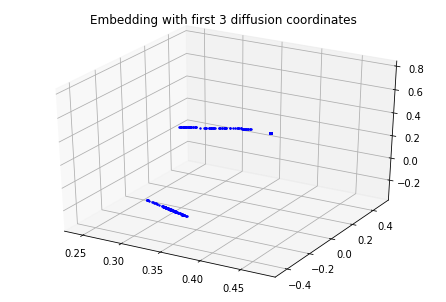

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
for i in range(n): ax.scatter(Y[i][0],Y[i][1],Y[i][2],s=2, c='b')
ax.set_title('Embedding with first 3 diffusion coordinates')
plt.show()

4. #### Cluster via k-means

In [25]:
from sklearn.cluster import KMeans

clusters = 3    #group numbers

kmeans = KMeans(clusters)
kmeans = kmeans.fit(Y)
labels = array(kmeans.predict(Y)).reshape(n,1)

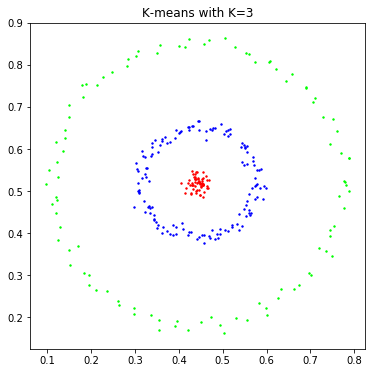

In [26]:
cmap = cm.brg
norm = Normalize(1, clusters)

for i in range(n):
    plt.scatter(ori['data'][i][0], ori['data'][i][1], s=2, c=cmap(norm(labels[i]+1)) )
plt.title('K-means with K=3')
plt.gcf().set_size_inches(6,6)
plt.show()

### References

[1] R.R. Coifman and S. Lafon, Diffusion maps, 21(1):5–30, 2006  
[2] J. de la Porte, B. M. Herbst, W. Hereman, S. J. van der Walt., An Introduction to Diffusion Maps  
[3] L. Zelnik-Manor and P. Perona, Self-Tuning Spectral Clustering, NIPS 2004